In [1]:
 # Network Intrusion Detection Using Spark
 # Exploratory Data Analysis (KDD) 
  ## Getting the data and creating the RDD

In [2]:
file_location = "/FileStore/tables/kddcup_data_10_percent-d8e1d.gz"
raw_data = sc.textFile(file_location)

'''Spark’s MLlib provides column summary statistics for RDD[Vector] through the function colStats available in Statistics. The method returns an instance of MultivariateStatisticalSummary, which contains the column-wise max, min, mean, variance, and number of nonzeros, as well as the total count.'''

from pyspark.mllib.stat import Statistics 
from math import sqrt 


#Let’s represent each network interaction in our dataset as a dense vector. For that we will use the NumPy array type.


import numpy as np

def parse_interaction(line):
    line_split = line.split(",")
    # keep just numeric and logical values
    symbolic_indexes = [1,2,3,41]
    clean_line_split = [item for i,item in enumerate(line_split) if i not in symbolic_indexes]
    return np.array([float(x) for x in clean_line_split])

vector_data = raw_data.map(parse_interaction)



In [3]:
# Summary Statistics
# Compute column summary statistics.

summary = Statistics.colStats(vector_data)

print("Duration Statistics:")
print(" Mean: {}".format(round(summary.mean()[0],3)))
print(" St. deviation: {}".format(round(sqrt(summary.variance()[0]),3)))
print(" Max value: {}".format(round(summary.max()[0],3)))
print(" Min value: {}".format(round(summary.min()[0],3)))
print(" Total value count: {}".format(summary.count()))
print(" Number of non-zero values: {}".format(summary.numNonzeros()[0]))


Duration Statistics:
 Mean: 47.979
 St. deviation: 707.746
 Max value: 58329.0
 Min value: 0.0
 Total value count: 494021
 Number of non-zero values: 12350.0

In [4]:
# Summary Statistics By Label

'''The interesting part of summary statistics, in our case, comes from being able to obtain them by the type of network attack or ‘label’ in our dataset. By doing so we will be able to better characterise our dataset dependent variable in terms of the independent variables range of values.

If we want to do such a thing we could filter our RDD containing labels as keys and vectors as values. For that we just need to adapt our parse_interaction function to return a tuple with both elements.

'''


def parse_interaction_with_key(line):
    line_split = line.split(",")
    # keep just numeric and logical values
    symbolic_indexes = [1,2,3,41]
    clean_line_split = [item for i,item in enumerate(line_split) if i not in symbolic_indexes]
    return (line_split[41], np.array([float(x) for x in clean_line_split]))

label_vector_data = raw_data.map(parse_interaction_with_key)
''''''
normal_label_data = label_vector_data.filter(lambda x: x[0]=="normal.")
normal_summary = Statistics.colStats(normal_label_data.values())
print("Duration Statistics for label: {}".format("normal"))
print(" Mean: {}".format(normal_summary.mean()[0],3))
print(" St. deviation: {}".format(round(sqrt(normal_summary.variance()[0]),3)))
print(" Max value: {}".format(round(normal_summary.max()[0],3)))
print(" Min value: {}".format(round(normal_summary.min()[0],3)))
print(" Total value count: {}".format(normal_summary.count()))
print(" Number of non-zero values: {}".format(normal_summary.numNonzeros()[0]))

Duration Statistics for label: normal
 Mean: 216.65732231336938
 St. deviation: 1359.213
 Max value: 58329.0
 Min value: 0.0
 Total value count: 97278
 Number of non-zero values: 11690.0

In [5]:
def summary_by_label(raw_data, label):
    label_vector_data = raw_data.map(parse_interaction_with_key).filter(lambda x: x[0]==label)
    return Statistics.colStats(label_vector_data.values())
  
normal_sum = summary_by_label(raw_data, "normal.")

print ("Duration Statistics for label: {}".format("normal"))
print(" Mean: {}".format(normal_sum.mean()[0],3))
print(" St. deviation: {}".format(round(sqrt(normal_sum.variance()[0]),3)))
print(" Max value: {}".format(round(normal_sum.max()[0],3)))
print(" Min value: {}".format(round(normal_sum.min()[0],3)))
print(" Total value count: {}".format(normal_sum.count()))
print(" Number of non-zero values: {}".format(normal_sum.numNonzeros()[0]))


Duration Statistics for label: normal
 Mean: 216.65732231336938
 St. deviation: 1359.213
 Max value: 58329.0
 Min value: 0.0
 Total value count: 97278
 Number of non-zero values: 11690.0

In [6]:
guess_passwd_summary = summary_by_label(raw_data, "guess_passwd.")

print("Duration Statistics for label: {}".format("guess_password"))
print(" Mean: {}".format(guess_passwd_summary.mean()[0],3))
print(" St. deviation: {}".format(round(sqrt(guess_passwd_summary.variance()[0]),3)))
print(" Max value: {}".format(round(guess_passwd_summary.max()[0],3)))
print(" Min value: {}".format(round(guess_passwd_summary.min()[0],3)))
print(" Total value count: {}".format(guess_passwd_summary.count()))
print(" Number of non-zero values: {}".format(guess_passwd_summary.numNonzeros()[0]))


Duration Statistics for label: guess_password
 Mean: 2.7169811320754715
 St. deviation: 11.88
 Max value: 60.0
 Min value: 0.0
 Total value count: 53
 Number of non-zero values: 4.0

In [7]:
label_list = ["back.","buffer_overflow.","ftp_write.","guess_passwd.",
              "imap.","ipsweep.","land.","loadmodule.","multihop.",
              "neptune.","nmap.","normal.","perl.","phf.","pod.","portsweep.",
              "rootkit.","satan.","smurf.","spy.","teardrop.","warezclient.",
              "warezmaster."]

stats_by_label = [(label, summary_by_label(raw_data, label)) for label in label_list]
duration_by_label = [ 
    (stat[0], np.array([float(stat[1].mean()[0]), float(sqrt(stat[1].variance()[0])), float(stat[1].min()[0]), float(stat[1].max()[0]), int(stat[1].count())])) 
    for stat in stats_by_label]


In [8]:
import pandas as pd
pd.set_option('display.max_columns', 50)

stats_by_label_df = pd.DataFrame.from_items(duration_by_label, columns=["Mean", "Std Dev", "Min", "Max", "Count"], orient='index')
print("Duration statistics, by label")
print(stats_by_label_df)

Duration statistics, by label
 Mean Std Dev Min Max Count
back. 0.128915 1.110062 0.0 14.0 2203.0
buffer_overflow. 91.700000 97.514685 0.0 321.0 30.0
ftp_write. 32.375000 47.449033 0.0 134.0 8.0
guess_passwd. 2.716981 11.879811 0.0 60.0 53.0
imap. 6.000000 14.174240 0.0 41.0 12.0
ipsweep. 0.034483 0.438439 0.0 7.0 1247.0
land. 0.000000 0.000000 0.0 0.0 21.0
loadmodule. 36.222222 41.408869 0.0 103.0 9.0
multihop. 184.000000 253.851006 0.0 718.0 7.0
neptune. 0.000000 0.000000 0.0 0.0 107201.0
nmap. 0.000000 0.000000 0.0 0.0 231.0
normal. 216.657322 1359.213469 0.0 58329.0 97278.0
perl. 41.333333 14.843629 25.0 54.0 3.0
phf. 4.500000 5.744563 0.0 12.0 4.0
pod. 0.000000 0.000000 0.0 0.0 264.0
portsweep. 1915.299038 7285.125159 0.0 42448.0 1040.0
rootkit. 100.800000 216.185003 0.0 708.0 10.0
satan. 0.040277 0.522433 0.0 11.0 1589.0
smurf. 0.000000 0.000000 0.0 0.0 280790.0
spy. 318.000000 26.870058 299.0 337.0 2.0
teardrop. 0.000000 0.000000 0.0 0.0 979.0
warezclient. 615.257843 2207.694966 0.0 15168.0 1020.0
warezmaster. 15.050000 33.385271 0.0 156.0 20.0

In [9]:
def get_variable_stats_df(stats_by_label, column_i):
    column_stats_by_label = [
        (stat[0], np.array([float(stat[1].mean()[column_i]), float(sqrt(stat[1].variance()[column_i])), float(stat[1].min()[column_i]), float(stat[1].max()[column_i]), int(stat[1].count())])) 
        for stat in stats_by_label
    ]
    return pd.DataFrame.from_items(column_stats_by_label, columns=["Mean", "Std Dev", "Min", "Max", "Count"], orient='index')


In [10]:
get_variable_stats_df(stats_by_label,0)

Out[ 11 ]: 
 Mean Std Dev Min Max Count
back. 0.128915 1.110062 0.0 14.0 2203.0
buffer_overflow. 91.700000 97.514685 0.0 321.0 30.0
ftp_write. 32.375000 47.449033 0.0 134.0 8.0
guess_passwd. 2.716981 11.879811 0.0 60.0 53.0
imap. 6.000000 14.174240 0.0 41.0 12.0
ipsweep. 0.034483 0.438439 0.0 7.0 1247.0
land. 0.000000 0.000000 0.0 0.0 21.0
loadmodule. 36.222222 41.408869 0.0 103.0 9.0
multihop. 184.000000 253.851006 0.0 718.0 7.0
neptune. 0.000000 0.000000 0.0 0.0 107201.0
nmap. 0.000000 0.000000 0.0 0.0 231.0
normal. 216.657322 1359.213469 0.0 58329.0 97278.0
perl. 41.333333 14.843629 25.0 54.0 3.0
phf. 4.500000 5.744563 0.0 12.0 4.0
pod. 0.000000 0.000000 0.0 0.0 264.0
portsweep. 1915.299038 7285.125159 0.0 42448.0 1040.0
rootkit. 100.800000 216.185003 0.0 708.0 10.0
satan. 0.040277 0.522433 0.0 11.0 1589.0
smurf. 0.000000 0.000000 0.0 0.0 280790.0
spy. 318.000000 26.870058 299.0 337.0 2.0
teardrop. 0.000000 0.000000 0.0 0.0 979.0
warezclient. 615.257843 2207.694966 0.0 15168.0 1020.0
warezmaster. 15.050000 33.385271 0.0 156.0 20.0

In [11]:
print("src_bytes statistics, by label")
print(get_variable_stats_df(stats_by_label,1))

src_bytes statistics, by label
 Mean Std Dev Min Max Count
back. 54156.355878 3.159360e+03 13140.0 54540.0 2203.0
buffer_overflow. 1400.433333 1.337133e+03 0.0 6274.0 30.0
ftp_write. 220.750000 2.677476e+02 0.0 676.0 8.0
guess_passwd. 125.339623 3.037860e+00 104.0 126.0 53.0
imap. 347.583333 6.299260e+02 0.0 1492.0 12.0
ipsweep. 10.083400 5.231658e+00 0.0 18.0 1247.0
land. 0.000000 0.000000e+00 0.0 0.0 21.0
loadmodule. 151.888889 1.277453e+02 0.0 302.0 9.0
multihop. 435.142857 5.409604e+02 0.0 1412.0 7.0
neptune. 0.000000 0.000000e+00 0.0 0.0 107201.0
nmap. 24.116883 5.941987e+01 0.0 207.0 231.0
normal. 1157.047524 3.422612e+04 0.0 2194619.0 97278.0
perl. 265.666667 4.932883e+00 260.0 269.0 3.0
phf. 51.000000 0.000000e+00 51.0 51.0 4.0
pod. 1462.651515 1.250980e+02 564.0 1480.0 264.0
portsweep. 666707.436538 2.150067e+07 0.0 693375640.0 1040.0
rootkit. 294.700000 5.385782e+02 0.0 1727.0 10.0
satan. 1.337319 4.294620e+01 0.0 1710.0 1589.0
smurf. 935.772300 2.000224e+02 520.0 1032.0 280790.0
spy. 174.500000 8.838835e+01 112.0 237.0 2.0
teardrop. 28.000000 0.000000e+00 28.0 28.0 979.0
warezclient. 300219.562745 1.200905e+06 30.0 5135678.0 1020.0
warezmaster. 49.300000 2.121551e+02 0.0 950.0 20.0

In [12]:
def get_variable_stats_df(stats_by_label, column_i):
    column_stats_by_label = [
        (stat[0], np.array([float(stat[1].mean()[column_i]), float(sqrt(stat[1].variance()[column_i])), float(stat[1].min()[column_i]), float(stat[1].max()[column_i]), int(stat[1].count())])) 
        for stat in stats_by_label
    ]
    return pd.DataFrame.from_items(column_stats_by_label, columns=["Mean", "Std Dev", "Min", "Max", "Count"], orient='index')


In [13]:
get_variable_stats_df(stats_by_label,0)

Out[ 14 ]: 
 Mean Std Dev Min Max Count
back. 0.128915 1.110062 0.0 14.0 2203.0
buffer_overflow. 91.700000 97.514685 0.0 321.0 30.0
ftp_write. 32.375000 47.449033 0.0 134.0 8.0
guess_passwd. 2.716981 11.879811 0.0 60.0 53.0
imap. 6.000000 14.174240 0.0 41.0 12.0
ipsweep. 0.034483 0.438439 0.0 7.0 1247.0
land. 0.000000 0.000000 0.0 0.0 21.0
loadmodule. 36.222222 41.408869 0.0 103.0 9.0
multihop. 184.000000 253.851006 0.0 718.0 7.0
neptune. 0.000000 0.000000 0.0 0.0 107201.0
nmap. 0.000000 0.000000 0.0 0.0 231.0
normal. 216.657322 1359.213469 0.0 58329.0 97278.0
perl. 41.333333 14.843629 25.0 54.0 3.0
phf. 4.500000 5.744563 0.0 12.0 4.0
pod. 0.000000 0.000000 0.0 0.0 264.0
portsweep. 1915.299038 7285.125159 0.0 42448.0 1040.0
rootkit. 100.800000 216.185003 0.0 708.0 10.0
satan. 0.040277 0.522433 0.0 11.0 1589.0
smurf. 0.000000 0.000000 0.0 0.0 280790.0
spy. 318.000000 26.870058 299.0 337.0 2.0
teardrop. 0.000000 0.000000 0.0 0.0 979.0
warezclient. 615.257843 2207.694966 0.0 15168.0 1020.0
warezmaster. 15.050000 33.385271 0.0 156.0 20.0

In [14]:
print("src_bytes statistics, by label")
get_variable_stats_df(stats_by_label,1)

src_bytes statistics, by label
 Out[ 15 ]: 
 Mean Std Dev Min Max Count
back. 54156.355878 3.159360e+03 13140.0 54540.0 2203.0
buffer_overflow. 1400.433333 1.337133e+03 0.0 6274.0 30.0
ftp_write. 220.750000 2.677476e+02 0.0 676.0 8.0
guess_passwd. 125.339623 3.037860e+00 104.0 126.0 53.0
imap. 347.583333 6.299260e+02 0.0 1492.0 12.0
ipsweep. 10.083400 5.231658e+00 0.0 18.0 1247.0
land. 0.000000 0.000000e+00 0.0 0.0 21.0
loadmodule. 151.888889 1.277453e+02 0.0 302.0 9.0
multihop. 435.142857 5.409604e+02 0.0 1412.0 7.0
neptune. 0.000000 0.000000e+00 0.0 0.0 107201.0
nmap. 24.116883 5.941987e+01 0.0 207.0 231.0
normal. 1157.047524 3.422612e+04 0.0 2194619.0 97278.0
perl. 265.666667 4.932883e+00 260.0 269.0 3.0
phf. 51.000000 0.000000e+00 51.0 51.0 4.0
pod. 1462.651515 1.250980e+02 564.0 1480.0 264.0
portsweep. 666707.436538 2.150067e+07 0.0 693375640.0 1040.0
rootkit. 294.700000 5.385782e+02 0.0 1727.0 10.0
satan. 1.337319 4.294620e+01 0.0 1710.0 1589.0
smurf. 935.772300 2.000224e+02 520.0 1032.0 280790.0
spy. 174.500000 8.838835e+01 112.0 237.0 2.0
teardrop. 28.000000 0.000000e+00 28.0 28.0 979.0
warezclient. 300219.562745 1.200905e+06 30.0 5135678.0 1020.0
warezmaster. 49.300000 2.121551e+02 0.0 950.0 20.0

In [15]:
#Corelation 
'''Correlations
Spark’s MLlib supports Pearson’s and Spearman’s to calculate pairwise correlation methods among many series. Both of them are provided by the corr method in the Statistics package.

We have two options as input. Either two RDD[Double]s or an RDD[Vector]. In the first case the output will be a Double value, while in the second a whole correlation Matrix. Due to the nature of our data, we will obtain the second.'''

from pyspark.mllib.stat import Statistics 
correlation_matrix = Statistics.corr(vector_data, method="spearman")

In [16]:
import pandas as pd
pd.set_option('display.max_columns', 50)

col_names = ["duration","src_bytes","dst_bytes","land","wrong_fragment",
             "urgent","hot","num_failed_logins","logged_in","num_compromised",
             "root_shell","su_attempted","num_root","num_file_creations",
             "num_shells","num_access_files","num_outbound_cmds",
             "is_hot_login","is_guest_login","count","srv_count","serror_rate",
             "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
             "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

corr_df = pd.DataFrame(correlation_matrix, index=col_names, columns=col_names)

corr_df

Out[ 17 ]: 
 duration src_bytes dst_bytes land \
duration 1.000000 1.419628e-02 0.299189 -0.001068 
src_bytes 0.014196 1.000000e+00 -0.167931 -0.009404 
dst_bytes 0.299189 -1.679306e-01 1.000000 -0.003040 
land -0.001068 -9.403731e-03 -0.003040 1.000000 
wrong_fragment -0.008025 -1.935835e-02 -0.022659 -0.000333 
urgent 0.017883 9.380528e-05 0.007234 -0.000065 
hot 0.108639 1.139201e-01 0.193156 -0.000539 
num_failed_logins 0.014363 -8.395950e-03 0.021952 -0.000076 
logged_in 0.159564 -8.970213e-02 0.882185 -0.002784 
num_compromised 0.010687 1.185618e-01 0.169772 -0.000447 
root_shell 0.040425 3.066817e-03 0.026054 -0.000093 
su_attempted 0.026015 2.282074e-03 0.012192 -0.000049 
num_root 0.013401 -2.049860e-03 -0.003884 -0.000230 
num_file_creations 0.061099 2.771005e-02 0.034154 -0.000149 
num_shells 0.008632 1.440256e-02 -0.000054 -0.000076 
num_access_files 0.019407 -1.496982e-03 0.065776 -0.000211 
num_outbound_cmds -0.000019 -4.227269e-07 -0.000026 -0.002873 
is_hot_login -0.000011 2.999489e-06 0.000035 0.002095 
is_guest_login 0.205606 2.751087e-02 0.085947 -0.000250 
count -0.259032 6.662300e-01 -0.639157 -0.010939 
srv_count -0.250139 7.226089e-01 -0.497683 -0.010128 
serror_rate -0.074211 -6.574602e-01 -0.205848 0.014160 
srv_serror_rate -0.073663 -6.523907e-01 -0.198715 0.014342 
rerror_rate -0.025936 -3.421804e-01 -0.100958 -0.000451 
srv_rerror_rate -0.026420 -3.329772e-01 -0.081307 -0.001690 
same_srv_rate 0.062291 7.440460e-01 0.229677 0.002153 
diff_srv_rate -0.050875 -7.399881e-01 -0.222572 -0.001846 
srv_diff_host_rate 0.123621 -1.040416e-01 0.521003 0.020679 
dst_host_count -0.161107 1.303771e-01 -0.611972 -0.019923 
dst_host_srv_count -0.217167 7.419795e-01 0.024124 -0.012341 
dst_host_same_srv_rate -0.211979 7.291513e-01 0.055033 0.002576 
dst_host_diff_srv_rate 0.231644 -7.129655e-01 -0.035073 -0.001803 
dst_host_same_src_port_rate -0.065202 8.150389e-01 -0.396195 0.004265 
dst_host_srv_diff_host_rate 0.100692 -1.402309e-01 0.578557 0.016171 
dst_host_serror_rate -0.056753 -6.459195e-01 -0.167047 0.013566 
dst_host_srv_serror_rate -0.057298 -6.417916e-01 -0.158378 0.012265 
dst_host_rerror_rate -0.007759 -2.973380e-01 -0.003042 0.000388 
dst_host_srv_rerror_rate -0.013891 -3.005806e-01 0.001621 -0.001816 

 wrong_fragment urgent hot \
duration -0.008025 0.017883 0.108639 
src_bytes -0.019358 0.000094 0.113920 
dst_bytes -0.022659 0.007234 0.193156 
land -0.000333 -0.000065 -0.000539 
wrong_fragment 1.000000 -0.000150 -0.004042 
urgent -0.000150 1.000000 0.008594 
hot -0.004042 0.008594 1.000000 
num_failed_logins -0.000568 0.063009 0.112560 
logged_in -0.020911 0.006821 0.189126 
num_compromised -0.003370 0.031765 0.811529 
root_shell -0.000528 0.067437 0.101983 
su_attempted -0.000248 0.000020 -0.000400 
num_root -0.001727 0.061994 0.003096 
num_file_creations -0.001160 0.061383 0.028694 
num_shells -0.000507 -0.000066 0.009146 
num_access_files -0.001519 0.023380 0.004224 
num_outbound_cmds -0.000147 0.012896 -0.000387 
is_hot_login 0.000441 0.005176 -0.000245 
is_guest_login -0.001869 -0.000100 0.463706 
count -0.057711 -0.004779 -0.120847 
srv_count -0.029117 -0.004799 -0.114735 
serror_rate -0.008849 -0.001338 -0.035487 
srv_serror_rate -0.023382 -0.001327 -0.034934 
rerror_rate 0.000430 -0.000705 0.013468 
srv_rerror_rate -0.012676 -0.000726 0.052003 
same_srv_rate 0.010218 0.001521 0.041342 
diff_srv_rate -0.009386 -0.001522 -0.040555 
srv_diff_host_rate 0.012117 -0.000788 0.032141 
dst_host_count -0.029149 -0.005895 -0.074178 
dst_host_srv_count -0.058225 -0.005698 -0.017960 
dst_host_same_srv_rate -0.049560 -0.004079 0.018783 
dst_host_diff_srv_rate 0.055542 0.005209 -0.017198 
dst_host_same_src_port_rate -0.015449 -0.001940 -0.086998 
dst_host_srv_diff_host_rate 0.007306 -0.000976 -0.014141 
dst_host_serror_rate 0.010387 -0.001379 -0.004706 
dst_host_srv_serror_rate -0.024117 -0.001369 -0.010721 
dst_host_rerror_rate 0.046656 -0.000788 0.199019 
dst_host_srv_rerror_rate -0.013666 -0.000784 0.18

In [17]:
# get a boolean dataframe where true means that a pair of variables is highly correlated
highly_correlated_df = (abs(corr_df) > .8) & (corr_df < 1.0)
# get the names of the variables so we can use them to slice the dataframe
correlated_vars_index = (highly_correlated_df==True).any()
correlated_var_names = correlated_vars_index[correlated_vars_index==True].index
# slice it
highly_correlated_df.loc[correlated_var_names,correlated_var_names]

Out[ 18 ]: 
 src_bytes dst_bytes hot logged_in \
src_bytes False False False False 
dst_bytes False False False True 
hot False False False False 
logged_in False True False False 
num_compromised False False True False 
num_outbound_cmds False False False False 
is_hot_login False False False False 
count False False False False 
srv_count False False False False 
serror_rate False False False False 
srv_serror_rate False False False False 
rerror_rate False False False False 
srv_rerror_rate False False False False 
same_srv_rate False False False False 
diff_srv_rate False False False False 
dst_host_count False False False False 
dst_host_srv_count False False False False 
dst_host_same_srv_rate False False False False 
dst_host_diff_srv_rate False False False False 
dst_host_same_src_port_rate True False False False 
dst_host_srv_diff_host_rate False False False False 
dst_host_serror_rate False False False False 
dst_host_srv_serror_rate False False False False 
dst_host_rerror_rate False False False False 
dst_host_srv_rerror_rate False False False False 

 num_compromised num_outbound_cmds is_hot_login \
src_bytes False False False 
dst_bytes False False False 
hot True False False 
logged_in False False False 
num_compromised False False False 
num_outbound_cmds False False True 
is_hot_login False True False 
count False False False 
srv_count False False False 
serror_rate False False False 
srv_serror_rate False False False 
rerror_rate False False False 
srv_rerror_rate False False False 
same_srv_rate False False False 
diff_srv_rate False False False 
dst_host_count False False False 
dst_host_srv_count False False False 
dst_host_same_srv_rate False False False 
dst_host_diff_srv_rate False False False 
dst_host_same_src_port_rate False False False 
dst_host_srv_diff_host_rate False False False 
dst_host_serror_rate False False False 
dst_host_srv_serror_rate False False False 
dst_host_rerror_rate False False False 
dst_host_srv_rerror_rate False False False 

 count srv_count serror_rate srv_serror_rate \
src_bytes False False False False 
dst_bytes False False False False 
hot False False False False 
logged_in False False False False 
num_compromised False False False False 
num_outbound_cmds False False False False 
is_hot_login False False False False 
count False True False False 
srv_count True False False False 
serror_rate False False False True 
srv_serror_rate False False True False 
rerror_rate False False False False 
srv_rerror_rate False False False False 
same_srv_rate False False True True 
diff_srv_rate False False True True 
dst_host_count False False False False 
dst_host_srv_count False False False False 
dst_host_same_srv_rate False False False False 
dst_host_diff_srv_rate False False False False 
dst_host_same_src_port_rate False True False False 
dst_host_srv_diff_host_rate False False False False 
dst_host_serror_rate False False True True 
dst_host_srv_serror_rate False False True True 
dst_host_rerror_rate False False False False 
dst_host_srv_rerror_rate False False False False 

 rerror_rate srv_rerror_rate same_srv_rate \
src_bytes False False False 
dst_bytes False False False 
hot False False False 
logged_in False False False 
num_compromised False False False 
num_outbound_cmds False False False 
is_hot_login False False False 
count False False False 
srv_count False False False 
serror_rate False False True 
srv_serror_rate False False True 
rerror_rate False True False 
srv_rerror_rate True False False 
same_srv_rate False False False 
diff_srv_rate False False True 
dst_host_count False False False 
dst_host_srv_count False False True 
dst_host_same_srv_rate False False True 
dst_host_diff_srv_rate False False True 
dst_host_same_src_port_rate False False False 
dst_host_srv_diff_host_rate False False False 
dst_host_serror_rate False False True 
dst_host_srv_serror_rate False False True 
dst_host_rerror_rate True True False 
dst_host_srv_rerror_rate True True False 

 di

In [18]:
'''
Conclusion

The previous dataframe showed us which variables are highly correlated. We have kept just those variables with at least one strong correlation. We can use as we please, but a good way could be to do some model selection. That is, if we have a group of variables that are highly correlated, we can keep just one of them to represent the group under the assumption that they convey similar information as predictors. Reducing the number of variables will not improve our model accuracy, but it will make it easier to understand and also more efficient to compute.

For example, from the description of the KDD Cup 99 task we know that the variable dst_host_same_src_port_rate references the percentage of the last 100 connections to the same port, for the same destination host. In our correlation matrix (and auxiliar dataframes) we find that this one is highly and positively correlated to src_bytes and srv_count. The former is the number of bytes sent form source to destination. The later is the number of connections to the same service as the current connection in the past 2 seconds. We might decide not to include dst_host_same_src_port_rate in our model if we include the other two, as a way to reduce the number of variables and later one better interpret our models.
'''

Out[ 19 ]: '\nConclusion\n\nThe previous dataframe showed us which variables are highly correlated. We have kept just those variables with at least one strong correlation. We can use as we please, but a good way could be to do some model selection. That is, if we have a group of variables that are highly correlated, we can keep just one of them to represent the group under the assumption that they convey similar information as predictors. Reducing the number of variables will not improve our model accuracy, but it will make it easier to understand and also more efficient to compute.\n\nFor example, from the description of the KDD Cup 99 task we know that the variable dst_host_same_src_port_rate references the percentage of the last 100 connections to the same port, for the same destination host. In our correlation matrix (and auxiliar dataframes) we find that this one is highly and positively correlated to src_bytes and srv_count. The former is the number of bytes sent form source to destination. The later is the number of connections to the same service as the current connection in the past 2 seconds. We might decide not to include dst_host_same_src_port_rate in our model if we include the other two, as a way to reduce the number of variables and later one better interpret our models.\n'

In [19]:
# Spark’s machine learning library MLlib to build a Logistic Regression classifier for network attack detection

test_data_file  = "/FileStore/tables/corrected.gz"
test_raw_data = sc.textFile(test_data_file)

print("Test data size is {}".format(test_raw_data.count()))

Test data size is 311029

In [20]:
'''n our case, we are interested in detecting network attacks in general. We don’t need to detect which type of attack we are dealing with. Therefore we will tag each network interaction as non attack (i.e. ‘normal’ tag) or attack (i.e. anything else but ‘normal’).
'''

# Training Data
from pyspark.mllib.regression import LabeledPoint
from numpy import array

def parse_interaction(line):
    line_split = line.split(",")
    # leave_out = [1,2,3,41]
    clean_line_split = line_split[0:1]+line_split[4:41]
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

training_data = raw_data.map(parse_interaction)

In [21]:
test_data = test_raw_data.map(parse_interaction)

In [22]:
# Training Classifier

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from time import time

# Build the model
t0 = time()
logit_model = LogisticRegressionWithLBFGS.train(training_data)
tt = time() - t0

print("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 132.073 seconds

In [23]:
# EVALUATING THE MODEL ON NEW DATA

labels_and_preds = test_data.map(lambda p: (p.label, logit_model.predict(p.features)))
t0 = time()
test_accuracy = labels_and_preds.filter(lambda v_p: v_p[0]== v_p[1]).count() / float(test_data.count())
tt = time() - t0

In [24]:
print("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

Prediction made in 22.703 seconds. Test accuracy is 0.9048

In [25]:
'''Let’s proceed with the evaluation of our reduced model. First we need to provide training and testing datasets containing just the selected variables. For that we will define a new function to parse the raw data that keeps just what we need.

'''
# Model selection
# EVALUATING THE NEW MODEL

def parse_interaction_corr(line):
    line_split = line.split(",")
    # leave_out = [1,2,3,25,27,35,38,40,41]
    clean_line_split = line_split[0:1]+line_split[4:25]+line_split[26:27]+line_split[28:35]+line_split[36:38]+line_split[39:40]
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

corr_reduced_training_data = raw_data.map(parse_interaction_corr)
corr_reduced_test_data = test_raw_data.map(parse_interaction_corr)

In [26]:
# Build the model
t0 = time()
logit_model_2 = LogisticRegressionWithLBFGS.train(corr_reduced_training_data)
tt = time() - t0

print("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 121.973 seconds

In [27]:
labels_and_preds = corr_reduced_test_data.map(lambda p: (p.label, logit_model_2.predict(p.features)))
t0 = time()
test_accuracy = labels_and_preds.filter(lambda v_p: v_p[0] == v_p[1]).count() / float(corr_reduced_test_data.count())
tt = time() - t0

print("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

Prediction made in 22.937 seconds. Test accuracy is 0.8158

In [28]:
#  USING HYPOTHESIS TESTING

'''Hypothesis testing is a powerful tool in statistical inference and learning to determine whether a result is statistically significant. MLlib supports Pearson’s chi-squared (χ2) tests for goodness of fit and independence. The goodness of fit test requires an input type of Vector, whereas the independence test requires a Matrix as input. Moreover, MLlib also supports the input type RDD[LabeledPoint] to enable feature selection via chi-squared independence tests. Again, these methods are part of the Statistics package.'''


feature_names = ["land","wrong_fragment",
             "urgent","hot","num_failed_logins","logged_in","num_compromised",
             "root_shell","su_attempted","num_root","num_file_creations",
             "num_shells","num_access_files","num_outbound_cmds",
             "is_hot_login","is_guest_login","count","srv_count","serror_rate",
             "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
             "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate"]


In [29]:
def parse_interaction_categorical(line):
    line_split = line.split(",")
    clean_line_split = line_split[6:41]
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

training_data_categorical = raw_data.map(parse_interaction_categorical)

In [30]:
from pyspark.mllib.stat import Statistics

chi = Statistics.chiSqTest(training_data_categorical)


In [31]:
import pandas as pd
pd.set_option('display.max_colwidth', 30)

records = [(result.statistic, result.pValue) for result in chi]

chi_df = pd.DataFrame(data=records, index= feature_names, columns=["Statistic","p-value"])

chi_df 

Out[ 32 ]: 
 Statistic p-value
land 3.191410 7.402616e-02
wrong_fragment 304.309631 0.000000e+00
urgent 4.814020 1.859331e-01
hot 1939.879629 0.000000e+00
num_failed_logins 24.935016 1.434174e-04
logged_in 312455.306674 0.000000e+00
num_compromised 635.549407 0.000000e+00
root_shell 17.030507 3.678404e-05
su_attempted 39.839347 2.233550e-09
num_root 2277.286802 0.000000e+00
num_file_creations 821.828337 0.000000e+00
num_shells 149.023961 0.000000e+00
num_access_files 1753.117284 0.000000e+00
num_outbound_cmds 0.000000 1.000000e+00
is_hot_login 0.000000 1.000000e+00
is_guest_login 515.383504 0.000000e+00
count 438656.520829 0.000000e+00
srv_count 221348.426646 0.000000e+00
serror_rate 26650.209505 0.000000e+00
srv_serror_rate 30009.256774 0.000000e+00
rerror_rate 747.695493 0.000000e+00
srv_rerror_rate 2227.301678 0.000000e+00
same_srv_rate 39218.869964 0.000000e+00
diff_srv_rate 38481.946673 0.000000e+00
srv_diff_host_rate 135374.306837 0.000000e+00
dst_host_count 245057.453656 0.000000e+00
dst_host_srv_count 136994.054761 0.000000e+00
dst_host_same_srv_rate 120218.197644 0.000000e+00
dst_host_diff_srv_rate 129405.698322 0.000000e+00
dst_host_same_src_port_rate 285015.925542 0.000000e+00
dst_host_srv_diff_host_rate 221692.890239 0.000000e+00
dst_host_serror_rate 37825.124327 0.000000e+00
dst_host_srv_serror_rate 42916.904442 0.000000e+00
dst_host_rerror_rate 8805.320953 0.000000e+00
dst_host_srv_rerror_rate 21137.696659 0.000000e+00

In [32]:
# Evaluating New Model 
''' first parse_interaction function will be to remove columns 6 and 19, corresponding to the two predictors that we want not to be part of our model.

'''
def parse_interaction_chi(line):
    line_split = line.split(",")
    # leave_out = [1,2,3,6,19,41]
    clean_line_split = line_split[0:1] + line_split[4:6] + line_split[7:19] + line_split[20:41]
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

training_data_chi = raw_data.map(parse_interaction_chi)
test_data_chi = test_raw_data.map(parse_interaction_chi)

In [33]:
# Build the model
t0 = time()
logit_model_chi = LogisticRegressionWithLBFGS.train(training_data_chi)
tt = time() - t0

print("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 127.927 seconds

In [34]:
labels_and_preds = test_data_chi.map(lambda p: (p.label, logit_model_chi.predict(p.features)))
t0 = time()
test_accuracy = labels_and_preds.filter(lambda v_p: v_p[0] == v_p[1]).count() / float(test_data_chi.count())
tt = time() - t0

print("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

Prediction made in 22.473 seconds. Test accuracy is 0.9015

In [35]:
# Detecting network attacks using Decision Trees

In [36]:
'''Training a classification tree using MLlib requires some parameters:

Training data
Num classes
Categorical features info: a map from column to categorical variables arity. This is optional, although it should increase model accuracy. However it requires that we know the levels in our categorical variables in advance. second we need to parse our data to convert labels to integer values within the arity range.
Impurity metric
Tree maximum depth
And tree maximum number of bins'''



from pyspark.mllib.regression import LabeledPoint
from numpy import array

csv_data = raw_data.map(lambda x: x.split(","))
test_csv_data = test_raw_data.map(lambda x: x.split(","))

protocols = csv_data.map(lambda x: x[1]).distinct().collect()
services = csv_data.map(lambda x: x[2]).distinct().collect()
flags = csv_data.map(lambda x: x[3]).distinct().collect()


In [37]:
def create_labeled_point(line_split):
    # leave_out = [41]
    clean_line_split = line_split[0:41]
    
    # convert protocol to numeric categorical variable
    try: 
        clean_line_split[1] = protocols.index(clean_line_split[1])
    except:
        clean_line_split[1] = len(protocols)
        
    # convert service to numeric categorical variable
    try:
        clean_line_split[2] = services.index(clean_line_split[2])
    except:
        clean_line_split[2] = len(services)
    
    # convert flag to numeric categorical variable
    try:
        clean_line_split[3] = flags.index(clean_line_split[3])
    except:
        clean_line_split[3] = len(flags)
    
    # convert label to binary label
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
        
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

training_data = csv_data.map(create_labeled_point)
test_data = test_csv_data.map(create_labeled_point)


In [38]:
# Training a Classifier

In [39]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from time import time

# Build the model
t0 = time()
tree_model = DecisionTree.trainClassifier(training_data, numClasses=2, 
                                          categoricalFeaturesInfo={1: len(protocols), 2: len(services), 3: len(flags)},
                                          impurity='gini', maxDepth=4, maxBins=100)
tt = time() - t0

print("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 18.878 seconds

In [40]:
predictions = tree_model.predict(test_data.map(lambda p: p.features))
labels_and_preds = test_data.map(lambda p: p.label).zip(predictions)

In [41]:
t0 = time()
test_accuracy = labels_and_preds.filter(lambda v_p: v_p[0] == v_p[1]).count() / float(test_data.count())

tt = time() - t0

print("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

Prediction made in 21.183 seconds. Test accuracy is 0.9196

In [42]:
# INTERPRETING THE MODEL
'''Understanding our tree splits is a great exercise in order to explain our classification labels in terms of predictors and the values they take. Using the toDebugString method in our three model we can obtain a lot of information regarding splits, nodes, etc.'''

Out[ 43 ]: 'Understanding our tree splits is a great exercise in order to explain our classification labels in terms of predictors and the values they take. Using the toDebugString method in our three model we can obtain a lot of information regarding splits, nodes, etc.'

In [43]:
print("Learned classification tree model:")
print(tree_model.toDebugString())


Learned classification tree model:
DecisionTreeModel classifier of depth 4 with 25 nodes
 If (feature 22 <= 59.0)
 If (feature 25 <= 0.5)
 If (feature 9 <= 0.5)
 If (feature 36 <= 0.46499999999999997)
 Predict: 0.0
 Else (feature 36 > 0.46499999999999997)
 Predict: 1.0
 Else (feature 9 > 0.5)
 If (feature 4 <= 1099.0)
 Predict: 0.0
 Else (feature 4 > 1099.0)
 Predict: 1.0
 Else (feature 25 > 0.5)
 If (feature 38 <= 0.105)
 If (feature 22 <= 6.5)
 Predict: 0.0
 Else (feature 22 > 6.5)
 Predict: 1.0
 Else (feature 38 > 0.105)
 If (feature 3 in {4.0,3.0})
 Predict: 0.0
 Else (feature 3 not in {4.0,3.0})
 Predict: 1.0
 Else (feature 22 > 59.0)
 If (feature 5 <= 2.0)
 If (feature 11 <= 0.5)
 Predict: 1.0
 Else (feature 11 > 0.5)
 Predict: 0.0
 Else (feature 5 > 2.0)
 If (feature 2 in {1.0,12.0,38.0,39.0})
 Predict: 0.0
 Else (feature 2 not in {1.0,12.0,38.0,39.0})
 If (feature 37 <= 0.13)
 Predict: 1.0
 Else (feature 37 > 0.13)
 Predict: 0.0

In [44]:
print("Service 0 is {}".format(services[0]))
print("Service 52 is {}".format(services[52]))

Service 0 is finger
Service 52 is gopher

In [45]:
#IMPORT LIBRARIES
from sklearn.metrics import roc_curve,auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics


# INSTANTIATE METRICS OBJECT
metrics = BinaryClassificationMetrics(labels_and_preds)

# AREA UNDER PRECISION-RECALL CURVE
print("Area under PR = %s" % metrics.areaUnderPR)

# AREA UNDER ROC CURVE
print("Area under ROC = %s" % metrics.areaUnderROC)
metrics = MulticlassMetrics(labels_and_preds)

# OVERALL STATISTICS
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score) 
print("Confusion Matrix ",metrics.confusionMatrix())
predictionAndLabelsDF = labels_and_preds.toDF()
predictionAndLabelsDF.registerTempTable("tmp_results");



Area under PR = 0.9033327902197944
Area under ROC = 0.8541498042376217
Summary Stats
Precision = 0.9195766311179986
Recall = 0.9195766311179986
F1 Score = 0.9195766311179986
Confusion Matrix DenseMatrix([[ 59703., 24124.],
 [ 890., 226312.]])

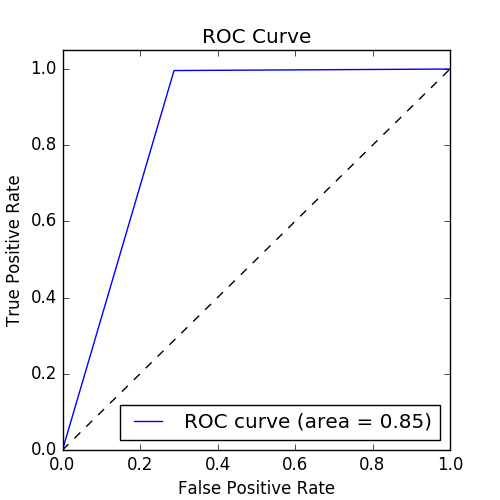

In [46]:
# MAKE PREDICTIONS AND PLOT ROC-CURVE

import matplotlib.pyplot as plt                        
from  sklearn.metrics import roc_curve,auc

#PREDICTIONS
from pyspark.sql.functions import col
data = sqlContext.sql("select * from tmp_results")
predictions_pddf = data.select(col("_1").alias("probability"), col("_2").alias("label"))
predictions_pddf = predictions_pddf.toPandas()
prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(predictions_pddf["label"], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

# PLOT ROC CURVES
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
display()

In [47]:
def create_labeled_point_minimal(line_split):
    # leave_out = [41]
    clean_line_split = line_split[3:4] + line_split[5:6] + line_split[22:23]
    
    # convert flag to numeric categorical variable
    try:
        clean_line_split[0] = flags.index(clean_line_split[0])
    except:
        clean_line_split[0] = len(flags)
    
    # convert label to binary label
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
        
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

training_data_minimal = csv_data.map(create_labeled_point_minimal)
test_data_minimal = test_csv_data.map(create_labeled_point_minimal)

In [48]:
# Build the model
t0 = time()
tree_model_minimal = DecisionTree.trainClassifier(training_data_minimal, numClasses=2, 
                                          categoricalFeaturesInfo={0: len(flags)},
                                          impurity='gini', maxDepth=3, maxBins=32)
tt = time() - t0

print("Classifier trained in {} seconds".format(round(tt,3)))

Classifier trained in 12.491 seconds

In [49]:
predictions_minimal = tree_model_minimal.predict(test_data_minimal.map(lambda p: p.features))
labels_and_preds_minimal = test_data_minimal.map(lambda p: p.label).zip(predictions_minimal)

In [50]:
t0 = time()
test_accuracy = labels_and_preds_minimal.filter(lambda v_p: v_p[0] == v_p[1]).count() / float(test_data_minimal.count())
tt = time() - t0

print("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

Prediction made in 14.084 seconds. Test accuracy is 0.9153

In [51]:
#IMPORT LIBRARIES
from sklearn.metrics import roc_curve,auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics


# INSTANTIATE METRICS OBJECT
metrics = BinaryClassificationMetrics(labels_and_preds_minimal)

# AREA UNDER PRECISION-RECALL CURVE
print("Area under PR = %s" % metrics.areaUnderPR)

# AREA UNDER ROC CURVE
print("Area under ROC = %s" % metrics.areaUnderROC)
metrics = MulticlassMetrics(labels_and_preds_minimal)

# OVERALL STATISTICS
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()

print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)
print("Confusion Matrix ",metrics.confusionMatrix())

predictionAndLabelsDF = labels_and_preds.toDF()
predictionAndLabelsDF.registerTempTable("tmp_results");



Area under PR = 0.8974111258021469
Area under ROC = 0.8485941506355452
Summary Stats
Precision = 0.9153358690025689
Recall = 0.9153358690025689
F1 Score = 0.9153358690025689
Confusion Matrix DenseMatrix([[ 59884., 25624.],
 [ 709., 224812.]])

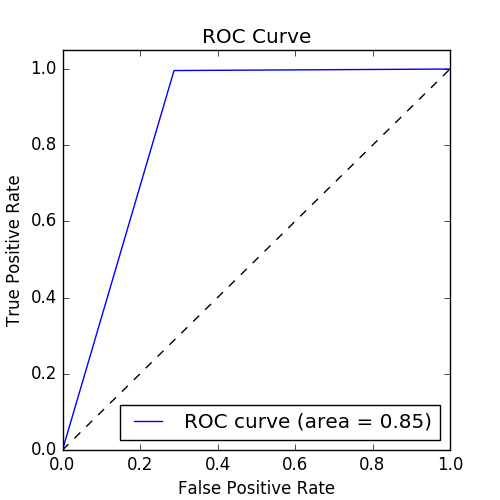

In [52]:
# MAKE PREDICTIONS AND PLOT ROC-CURVE

import matplotlib.pyplot as plt                        
from  sklearn.metrics import roc_curve,auc

#PREDICTIONS
from pyspark.sql.functions import col
data = sqlContext.sql("select * from tmp_results")
predictions_pddf = data.select(col("_1").alias("probability"), col("_2").alias("label"))
predictions_pddf = predictions_pddf.toPandas()
prob = predictions_pddf["probability"] 
fpr, tpr, thresholds = roc_curve(predictions_pddf["label"], prob, pos_label=1);
roc_auc = auc(fpr, tpr)

# PLOT ROC CURVES
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
display()

In [53]:
''' So we have trained a classification tree with just the three most important predictors, in half of the time, and with a not so bad accuracy. In fact, a classification tree is a very good model selection tool!'''



Out[ 55 ]: ' So we have trained a classification tree with just the three most important predictors, in half of the time, and with a not so bad accuracy. In fact, a classification tree is a very good model selection tool!'

In [54]:
from time import time


data_file = "/FileStore/tables/kddcup_data_10_percent-d8e1d.gz"
raw_data = sc.textFile(data_file)
print("Train data size is {}".format(raw_data.count()))
test_data_file = "/FileStore/tables/corrected.gz"
test_raw_data = sc.textFile(test_data_file)
print ("Test data size is {}".format(test_raw_data.count()))
csv_data = raw_data.map(lambda x: x.split(","))
test_csv_data = test_raw_data.map(lambda x: x.split(","))


from pyspark.mllib.regression import LabeledPoint
from numpy import array

def parse_interaction(line):
    line_split = line.split(",")
    # leave_out = [1,2,3,41]
    clean_line_split = line_split[0:1]+line_split[4:41]
    attack = 1.0
    if line_split[41]=='normal.':
        attack = 0.0
    return LabeledPoint(attack, array([float(x) for x in clean_line_split]))

training_data = raw_data.map(parse_interaction)
test_data = test_raw_data.map(parse_interaction)

Train data size is 494021
Test data size is 311029

In [55]:
from pyspark.mllib.tree import RandomForest


t0 = time()
tree_model = RandomForest.trainClassifier(training_data, numClasses=2,
                                          categoricalFeaturesInfo={},
                                          numTrees=10,featureSubsetStrategy="auto",
                                          impurity='gini', maxDepth=4, maxBins=100)
tt = time() - t0

print ("Classifier trained in {} seconds".format(round(tt,3)))
tt = time() - t0

print ("Classifier trained in {} seconds".format(round(tt,3)))


Classifier trained in 20.199 seconds
Classifier trained in 20.199 seconds

In [56]:
predictions = tree_model.predict(test_data.map(lambda p: p.features))
labels_and_preds = test_data.map(lambda p: p.label).zip(predictions)

t0 = time()
test_accuracy = labels_and_preds.filter(lambda vp: vp[0] == vp[1]).count() / float(test_data.count())
tt = time() - t0

print ("Prediction made in {} seconds. Test accuracy is {}".format(round(tt,3), round(test_accuracy,4)))

print ("Learned classification tree model:")
print (tree_model.toDebugString())


Prediction made in 17.901 seconds. Test accuracy is 0.9223
Learned classification tree model:
TreeEnsembleModel classifier with 10 trees

 Tree 0:
 If (feature 1 <= 519.5)
 If (feature 22 <= 0.545)
 If (feature 37 <= 0.995)
 Predict: 0.0
 Else (feature 37 > 0.995)
 If (feature 33 <= 0.005)
 Predict: 1.0
 Else (feature 33 > 0.005)
 Predict: 0.0
 Else (feature 22 > 0.545)
 If (feature 29 <= 147.0)
 If (feature 2 <= 2.0)
 Predict: 1.0
 Else (feature 2 > 2.0)
 Predict: 0.0
 Else (feature 29 > 147.0)
 If (feature 31 <= 0.035)
 Predict: 0.0
 Else (feature 31 > 0.035)
 Predict: 1.0
 Else (feature 1 > 519.5)
 If (feature 20 <= 33.5)
 If (feature 9 <= 0.5)
 If (feature 2 <= 2425.0)
 Predict: 0.0
 Else (feature 2 > 2425.0)
 Predict: 1.0
 Else (feature 9 > 0.5)
 If (feature 30 <= 0.305)
 Predict: 0.0
 Else (feature 30 > 0.305)
 Predict: 1.0
 Else (feature 20 > 33.5)
 Predict: 1.0
 Tree 1:
 If (feature 2 <= 2.0)
 If (feature 1 <= 1039.5)
 If (feature 8 <= 0.5)
 Predict: 1.0
 Else (feature 8 > 0.5)
 Predict: 0.0
 Else (feature 1 > 1039.5)
 Predict: 0.0
 Else (feature 2 > 2.0)
 If (feature 1 <= 2550.5)
 If (feature 24 <= 0.855)
 If (feature 6 <= 25.0)
 Predict: 0.0
 Else (feature 6 > 25.0)
 Predict: 1.0
 Else (feature 24 > 0.855)
 If (feature 34 <= 0.025)
 Predict: 0.0
 Else (feature 34 > 0.025)
 Predict: 1.0
 Else (feature 1 > 2550.5)
 If (feature 2 <= 2425.0)
 If (feature 36 <= 0.875)
 Predict: 0.0
 Else (feature 36 > 0.875)
 Predict: 1.0
 Else (feature 2 > 2425.0)
 If (feature 35 <= 0.035)
 Predict: 1.0
 Else (feature 35 > 0.035)
 Predict: 0.0
 Tree 2:
 If (feature 34 <= 0.985)
 If (feature 20 <= 75.5)
 If (feature 19 <= 91.5)
 If (feature 9 <= 0.5)
 Predict: 0.0
 Else (feature 9 > 0.5)
 Predict: 1.0
 Else (feature 19 > 91.5)
 If (feature 1 <= 102.5)
 Predict: 1.0
 Else (feature 1 > 102.5)
 Predict: 0.0
 Else (feature 20 > 75.5)
 If (feature 32 <= 0.065)
 If (feature 1 <= 395.0)
 Predict: 0.0
 Else (feature 1 > 395.0)
 Predict: 1.0
 Else (feature 32 > 0.065)
 If (feature 2 <= 2.0)
 Predict: 1.0
 Else (feature 2 > 2.0)
 Predict: 0.0
 Else (feature 34 > 0.985)
 If (feature 22 <= 0.01)
 Predict: 0.0
 Else (feature 22 > 0.01)
 If (feature 33 <= 0.045)
 Predict: 1.0
 Else (feature 33 > 0.045)
 If (feature 20 <= 1.5)
 Predict: 0.0
 Else (feature 20 > 1.5)
 Predict: 1.0
 Tree 3:
 If (feature 19 <= 36.5)
 If (feature 22 <= 0.545)
 If (feature 33 <= 0.45)
 Predict: 0.0
 Else (feature 33 > 0.45)
 Predict: 1.0
 Else (feature 22 > 0.545)
 If (feature 35 <= 0.065)
 Predict: 0.0
 Else (feature 35 > 0.065)
 If (feature 1 <= 0.5)
 Predict: 1.0
 Else (feature 1 > 0.5)
 Predict: 0.0
 Else (feature 19 > 36.5)
 If (feature 21 <= 0.055)
 If (feature 32 <= 0.92)
 If (feature 31 <= 0.015)
 Predict: 0.0
 Else (feature 31 > 0.015)
 Predict: 1.0
 Else (feature 32 > 0.92)
 If (feature 1 <= 519.5)
 Predict: 0.0
 Else (feature 1 > 519.5)
 Predict: 1.0
 Else (feature 21 > 0.055)
 If (feature 29 <= 74.0)
 Predict: 1.0
 Else (feature 29 > 74.0)
 If (feature 34 <= 0.095)
 Predict: 1.0
 Else (feature 34 > 0.095)
 Predict: 0.0
 Tree 4:
 If (feature 33 <= 0.005)
 If (feature 19 <= 36.5)
 If (feature 2 <= 2.0)
 If (feature 21 <= 0.625)
 Predict: 0.0
 Else (feature 21 > 0.625)
 Predict: 1.0
 Else (feature 2 > 2.0)
 If (feature 24 <= 0.15500000000000003)
 Predict: 0.0
 Else (feature 24 > 0.15500000000000003)
 Predict: 1.0
 Else (feature 19 > 36.5)
 If (feature 1 <= 519.5)
 If (feature 20 <= 35.5)
 Predict: 1.0
 Else (feature 20 > 35.5)
 Predict: 0.0
 Else (feature 1 > 519.5)
 Predict: 1.0
 Else (feature 33 > 0.005)
 If (feature 4 <= 0.5)
 If (feature 32 <= 0.995)
 If (feature 34 <= 0.815)
 Predict: 0.0
 Else (feature 34 > 0.815)
 Predict: 1.0
 Else (feature 32 > 0.995)
 Predict: 0.0
 Else (feature 4 > 0.5)
 Predict: 1.0
 Tree 5:
 If (feature 19 <= 36.5)
 If (feature 33 <= 0.45)
 If (feature 21 <= 0.625)
 If (feature 31 <= 0.9550000000000001)
 Predict: 0.0
 Else (feature 31 > 0.9550000000000001)
 Predict: 1.0
 Else (feature 21 > 0.625)
 Predict: 1.0
 Else (feature 33 > 0.45)
 